In [1]:
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import math, itertools, sys, os, pickle


BASE_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(1, BASE_DIR)
from config import device
from assistive_functions import *
from loss_functions import LQLossFH
from controllers.abstract import affine_controller
from controllers.empirical_controller import *
from experiments.scalar.LTI_sys import LTI_system
from experiments.scalar.scalar_assistive_functions import load_data


num_sampled_controllers = 20
dist_type = 'N biased'
T = 10
S = 8

random_seed = 33
random_state = np.random.RandomState(random_seed)


[INFO] running on CPU


/Users/mahrokh/anaconda3/envs/NOC/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load data
data_train, data_test, disturbance = load_data(
    dist_type=dist_type, S=S, # do not need train data
    T=T, random_seed=random_seed,
    S_test=None   # use a subset of available test data if not None
)

# Bootstrap data
repeats = 50
data_frac = 0.25
S_bootstrap = math.floor(data_frac*S)
data_boot_strap = [None]*repeats
for rep_num in range(repeats):
    data_boot_strap[rep_num] = np.zeros((S_bootstrap, T, data_train.shape[-1]))
    inds = random_state.choice(range(S), size=S_bootstrap, replace=True)
    for row_num, ind in enumerate(inds):
        data_boot_strap[rep_num][row_num, :, :] = data_train[ind, :, :]
        

In [3]:
file_path = os.path.join(BASE_DIR, 'experiments', 'scalar', 'saved_results')
eps = 0.1
prior_type_b = 'Gaussian_biased_wide' #'Uniform' #

# system
sys_np = LTI_system(
    A = np.array([[0.8]]),  # num_states*num_states
    B = np.array([[0.1]]),  # num_states*num_inputs
    C = np.array([[0.3]]),  # num_outputs*num_states
    x_init = 2*np.ones((1, 1)),  # num_states*1
    use_tensor=False
)
sys = LTI_system(
    sys_np.A, sys_np.B, sys_np.C, sys_np.x_init,
    use_tensor=True
)

# loss
Q = 5*torch.eye(sys.num_states).to(device)
R = 0.003*torch.eye(sys.num_inputs).to(device)
loss_bound = 1
sat_bound = torch.matmul(torch.matmul(torch.transpose(sys.x_init, 0, 1), Q) , sys.x_init)
lq_loss_bounded = LQLossFH(Q, R, T, loss_bound, sat_bound)
lq_loss_original = LQLossFH(Q, R, T, None, None)


# load controllers
filename = dist_type.replace(" ", "_")+'_ours_'+prior_type_b+'_T'+str(T)+'_S'+str(S)+'_eps'+str(int(eps*10))+'.pkl'
filename = os.path.join(file_path, filename)
filehandler = open(filename, 'rb')
res = pickle.load(filehandler)
filehandler.close()
assert num_sampled_controllers==len(res['av_test_loss_original'])

# init losses
test_loss_bounded = [None]*num_sampled_controllers
test_loss_original = [None]*num_sampled_controllers
train_loss_bounded = [None]*num_sampled_controllers
train_loss_original = [None]*num_sampled_controllers
boot_loss_bounded = np.zeros((repeats, num_sampled_controllers))
boot_loss_original = np.zeros((repeats, num_sampled_controllers))

# eval controllers
sampled_controllers = res['sampled_controllers'] 
for controller_num in range(num_sampled_controllers):
    sampled_controllers[controller_num] = affine_controller(
        np.array([[sampled_controllers[controller_num][0]]]), 
        np.array([[sampled_controllers[controller_num][1]]])
    )
    
    # eval on train data
    xs_train, _, us_train = sys.multi_rollout(
        sampled_controllers[controller_num], data_train
    )
    with torch.no_grad():
        train_loss_bounded[controller_num] = lq_loss_bounded.forward(xs_train,us_train).item()
        train_loss_original[controller_num] = lq_loss_original.forward(xs_train,us_train).item()

    # eval on test data
    xs_test, _, us_test = sys.multi_rollout(
        sampled_controllers[controller_num], data_test
    )
    with torch.no_grad():
        test_loss_bounded[controller_num] = lq_loss_bounded.forward(xs_test,us_test).item()
        test_loss_original[controller_num] = lq_loss_original.forward(xs_test,us_test).item()
    assert abs(test_loss_bounded[controller_num]-res['av_test_loss_bounded'][controller_num])<1e-6
    assert abs(test_loss_original[controller_num]-res['av_test_loss_original'][controller_num])<1e-6
    
    # eval on Bootstrap 
    for rep_num in range(repeats):
        xs_boot, _, us_boot = sys.multi_rollout(
            sampled_controllers[controller_num], data_boot_strap[rep_num]
        )
        with torch.no_grad():
            boot_loss_bounded[rep_num, controller_num] = lq_loss_bounded.forward(
                xs_boot,us_boot).item()
            boot_loss_original[rep_num, controller_num] = lq_loss_original.forward(
                xs_boot,us_boot).item()




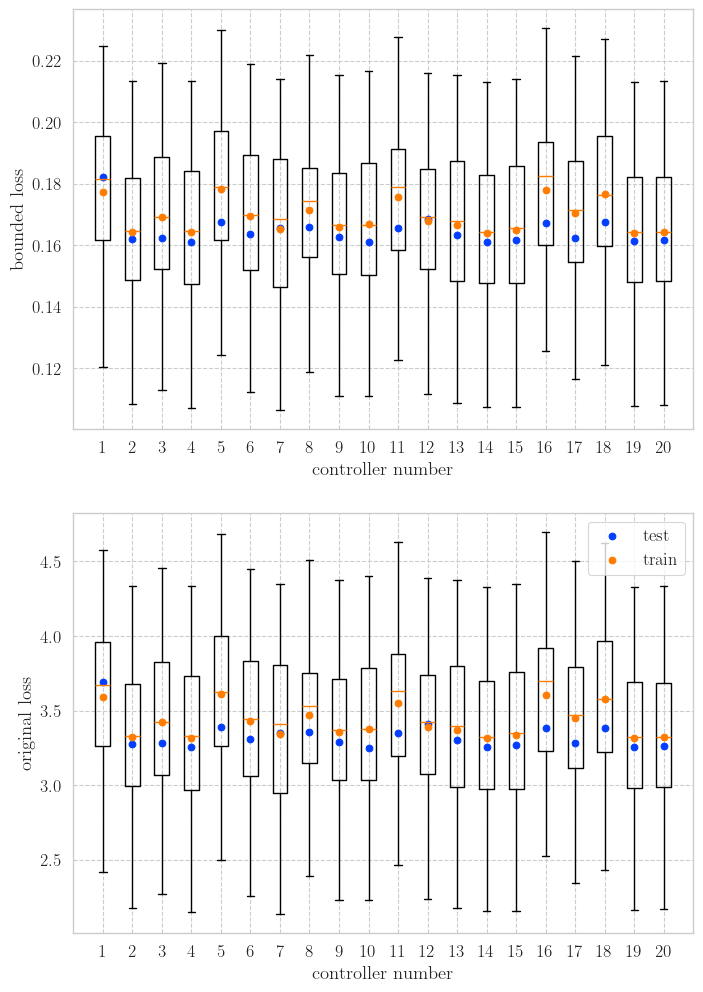

In [4]:
# ------ format ------
plt.rcParams['text.usetex'] = True
sns.set_theme(
    context='paper', style='whitegrid', palette='bright', 
    font='sans-serif', font_scale=1.4, color_codes=True, rc=None, 
)
sns.set_style({'grid.linestyle': '--'})
mpl.rc('font', family='serif', serif='Times New Roman')

fig, axs = plt.subplots(2, 1, figsize=(8, 12))
axs[0].boxplot(boot_loss_bounded)
axs[0].scatter(range(1, num_sampled_controllers+1), test_loss_bounded, label='test')
axs[0].scatter(range(1, num_sampled_controllers+1), train_loss_bounded, label='train')
axs[0].set_ylabel('bounded loss')

axs[1].boxplot(boot_loss_original)
axs[1].scatter(range(1, num_sampled_controllers+1), test_loss_original, label='test')
axs[1].scatter(range(1, num_sampled_controllers+1), train_loss_original, label='train')
axs[1].set_ylabel('original loss')

for ax in axs:
    ax.set_xlabel('controller number')
    ax.set_xlim(0, num_sampled_controllers+1)
    
plt.legend()


In [5]:
print('Controller Selection Strategies')
print('Dataset info: S = {:.0f}, prior = '.format(S)+prior_type_b)
print('Bootstrap info: repeats = {:.0f}, samples fraction = {:1.2f}'.format(repeats, data_frac)+'\n')

msg = 'test loss of the controller minimizing '
print(msg + 'random: {:.4f} (on average)'.format(sum(test_loss_bounded)/num_sampled_controllers))

ind = train_loss_bounded.index(min(train_loss_bounded))
# print(ind)
print(msg + 'train loss: {:.4f}'.format(test_loss_bounded[ind]))

boot_loss_av = np.mean(boot_loss_bounded, axis=0)
ind = np.argmin(boot_loss_av)
# print(ind)
print(msg + 'mean Bootstrap loss: {:.4f}'.format(test_loss_bounded[ind]))

boot_loss_quan = np.quantile(boot_loss_bounded, q=3/4, axis=0)
ind = np.argmin(boot_loss_quan)
# print(ind)
print(msg + '3/4 quantile Bootstrap loss: {:.4f}'.format(test_loss_bounded[ind]))

boot_loss_std = np.std(boot_loss_bounded, axis=0)
ind = np.argmin(boot_loss_av + 1.95*boot_loss_std)
# print(ind)
print(msg + 'mean+1.95*std Bootstrap loss: {:.4f}'.format(test_loss_bounded[ind]))

ind = test_loss_bounded.index(min(test_loss_bounded))
# print(ind)
print(msg + 'test loss: {:.4f} (ideal)'.format(test_loss_bounded[ind]))


Controller Selection Strategies
Dataset info: S = 8, prior = Gaussian_biased_wide
Bootstrap info: repeats = 50, samples fraction = 0.25

test loss of the controller minimizing random: 0.1647 (on average)
test loss of the controller minimizing train loss: 0.1611
test loss of the controller minimizing mean Bootstrap loss: 0.1611
test loss of the controller minimizing 3/4 quantile Bootstrap loss: 0.1621
test loss of the controller minimizing mean+1.95*std Bootstrap loss: 0.1612
test loss of the controller minimizing test loss: 0.1609 (ideal)
